# Modeling a Binary Star Population

Below is the code of an astronomy model of a fast-rotating star population found by the Kepler telescope. 

We start by importing all the astronomy files and reading the data.

In [2]:
from astropy.table import Table, join
import astropy.io.ascii as ascii
import astropy.io.fits

def read_data():
    targets = Table.read('MDM_targets.csv', format = 'ascii.csv')
    targets.rename_column('ï»¿KIC', 'KIC')
    data_set1 = Table.read('ajab8a33t1_mrt.txt', format = 'ascii.mrt')
    data_set2 = Table.read('ajab8a33t2_mrt.txt', format = 'ascii.mrt')
    McQuillan = Table.read('McQuillan.fit', format = 'fits')
    
    #Join the datasets
    d1_d2 = join(data_set1, data_set2)
    targets = join(targets, d1_d2)
    table = join(targets, McQuillan, join_type = 'left', keys = 'KIC')
    
    return table

#Save table
def write_data():
    table = read_data()
    table.write('Target_data.csv', format = 'ascii.csv')

#Read table
def read_table():
    
    return Table.read('Target_data.csv')

#Create an index for KIC targets
def KIC_index():
    table = read_data()
    index = table['KIC']
    
    return index

import pickle
#Get observation times and radial velocities
def rv_times(KIC_number):
    with open('full_rvs.pickle', 'rb') as f:
        docs, full_rvs = pickle.load(f)
    KIC_times, KIC_rvs = full_rvs[f"KIC{KIC_number}"]
    
    return KIC_times, KIC_rvs


Now we define functions to return known quanities from our target stars loaded above.

In [3]:
#Target Mass
def target_mass(KIC_number):
    table = read_table()
    target_mass = table['KIC', 'Mass']
    target_mass.add_index('KIC')
    mass = target_mass.loc[KIC_number]['Mass']
    
    return mass

#Target Orbital Period
def target_period(KIC_number):
    table = read_table()
    target_period = table['KIC', 'Prot']
    target_period.add_index('KIC')
    Prot = target_period.loc[KIC_number]['Prot']
    
    return Prot

# Model Unknown Parameters

We start by modeling the inclination angle. The inclination angle is the angle between the plane of the orbit and the observer. The inclination angle of the binary orbit follows a sine distribution, this is because there’s almost an infinite number of ways to have a 90 degree inclination angle but there are only two ways of getting a 0 degree inclination angle.

In [4]:
import numpy as np
from math import pi

# Inclination angle
def sin_distn():
    rand_uniform_array = np.random.uniform(0, pi/2, 300)
    i_angle = np.arccos((2 * rand_uniform_array)/pi)
    
    return i_angle

inclination_angle_array = sin_distn()


Next, we model the mass ratip (q) and phase angle (theta). The mass ratio is the mass of the primary star divided by the mass of the secondary star. The mass ratio follows a uniform distribution, which means that there is an equal probability of getting any value between 0 and 1. The phase angle is the angle at which the first observation was made. The phase angle follows a uniform distribution, which means that there is an equal probability of getting any value between 0 and 2π. 


In [5]:
# Mass ratio (primary mass / companion mass)
q_array = np.random.uniform(0,1, 200)

from astropy import units as u
#Phase angle
theta_array = np.random.uniform(0,2*pi, 200) * u.radian

# Astronomy Functions

Next we create a function to calculate the amplitude (semi-major axis) of the binary system. 

In [6]:
from astropy import constants as const
Gravitational_constant = const.G # Value = 6.67 x 10^-11 m^3/(kg s^2)

# Amplitude (semi-major axis)
def calculate_amplitude(mass1, q_array, inclination_angle_array, period):
    mass2 = mass1 * q_array
    orbital_period = (period * u.day).to(u.second)
    total_mass = mass1 + mass2
    amplitude = (
        ( ((mass2**3) / (total_mass**2))
        * (np.sin(inclination_angle_array)**3)
        *((2 * pi * Gravitational_constant) / orbital_period))**(1/3)
        )
    return amplitude # units of m/s


In astronomy, radial velocity is an object’s motion towards or away from the observer. Using Kepler’s 3rd law of planetary motion, we create functions to calculate radial velocity, and add white noise to account for errors in observations.

In [7]:
# Radial velocity
def calculate_radial_velocity(mass1, q_array, time_array, period , theta_array, inclination_angle_array):
    time_array = time_array.reshape(len(time_array), 1, 1, 1) 
    theta_array = theta_array.reshape(1, len(theta_array), 1, 1)
    q_array = q_array.reshape(1, 1, len(q_array),1)
    inclination_angle_array = inclination_angle_array.reshape(1, 1, 1, len(inclination_angle_array))
    
    amplitude = calculate_amplitude(mass1, q_array, inclination_angle_array, period)
    period =  period * u.day
    omega = (2*pi)/(period.to(u.second))
    radial_velocity = ((amplitude*np.cos(((omega*time_array).to(u.radian, equivalencies = u.dimensionless_angles())) + theta_array))) #units of m/s
    
    return radial_velocity # in m/s

# Add noise to radial velocity
def calculate_velocity_with_noise(mass1, q_array, time_array, period, std, theta_array, inclination_angle_array):
    radial_velocity_array = calculate_radial_velocity(mass1, q_array, time_array, period,theta_array,inclination_angle_array) #m/s
    noise = np.random.normal(0, std, size = radial_velocity_array.shape)  * (u.km/u.second)
    velocity_with_noise = radial_velocity_array + noise
    
    return (velocity_with_noise.to(u.km/u.s)) 


Next, we generate an array of radial velocities for each possible combination of parameters.

In [8]:
SUN_MASS = const.M_sun # Value = 1.98840987e+30 kg

def generate_rv_array(KICnumber):
    time_array, measured_rv = rv_times(KICnumber)
    time_array = np.array(time_array) *u.day
    measured_rv = np.array(measured_rv) * (u.km/u.s)
    std = 10 # standard deviation in km/s
    mass = target_mass(KICnumber) * SUN_MASS
    t_period = target_period(KICnumber) 
    rv_array = calculate_velocity_with_noise(mass, q_array, time_array, t_period, std, theta_array, inclination_angle_array) #m/sec
    
    return rv_array # in km/s

We generate a Chi-square value for each radial velocity curve, by comparing it with the actual radial velocity measured by the Kepler telescope.

In [9]:
def Chi_square_distribution(KICnumber):
    radial_velocities = generate_rv_array(KICnumber)
    time_array,measured_rv = rv_times(KICnumber)
    measured_rv = measured_rv * (u.km/u.s) #measured rv
    measured_rv = measured_rv.reshape(len(measured_rv), 1, 1, 1)
    chi_square = ((radial_velocities - measured_rv)**2) / ((10* u.km/u.s)**2)
    chi_values_array = np.sum(chi_square, axis = 0)
    
    return chi_values_array

Next, find the best fit curve which is the one with the lowest chi-square value, and we return the set of parameters that best fits the observed data.

In [10]:
def minimum(KICnumber):
    chi_values = Chi_square_distribution(KICnumber)
    min_value = chi_values.min() #returns the minimum value in the multidimensional array s
    max_value = chi_values.max()
    min_index = np.argwhere(chi_values == min_value)
    
    theta_value = theta_array[min_index[0][0]]
    q_value = q_array[min_index[0][1]]
    i_value = inclination_angle_array[min_index[0][2]]
    
    print(f"KIC target: KIC_{KICnumber}")
    print("max value is ", max_value)
    print("min value is ", min_value)
    print("theta value is ", theta_value)
    print("q value is ", q_value)
    print("inclination angle value is ", i_value)
    
    return [theta_value,q_value,i_value,min_value]

Lastly, we created a function that combines some of the steps described above.

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

def KIC_Model(KICnumber):
    #Declare paramters
    time_array, measured_rv = rv_times(KICnumber) 
    time_array = np.array(time_array) *u.day
    mass1 = target_mass(KICnumber) * SUN_MASS
    t_period = target_period(KICnumber)
    
    #Find minimum Chi-Square value and respective modeled parameters
    min_ = minimum(KICnumber)
    b_f_theta = np.array([min_[0].value]) * u.radian
    b_f_q = np.array([min_[1]])
    b_f_i = np.array([min_[2]])
    min_chi_value = np.array([min_[3]])
    #print(b_f_theta,b_f_q,b_f_i)

    #Hypothesis testing
    print('Experimental p value = ', min_chi_value)
    right_tail_value = stats.chi2.ppf(1-0.025, df = 2)#we use 2 degrees of freedom since we have 3 categories of modeled parameters, dof = n-1 = (theta, q, inc_angle) - 1
    print('Theoretical p value =', right_tail_value)
    if min_chi_value < right_tail_value:
        print('We have a binary system')
    elif min_chi_value > right_tail_value:
        print('We do not have a binary system')
    print("")

    
    #calculate best fit curve radial velocity and plot it with measured rv
    b_f_rv = calculate_radial_velocity(mass1, b_f_q, time_array, t_period, b_f_theta, b_f_i)
    sns.set()
    ax = plt.axes()
    ax.set(xlabel = 'time (days)', ylabel = 'radial velocity (km/sec)',
           title = f"KIC_{KICnumber} observed & measured rvs")
    plt.plot(time_array, (b_f_rv[:,0,0,0].to(u.km/u.s)).value, label = 'best fit rv curve', linestyle = ':')
    plt.plot(time_array,measured_rv, label = 'measured rv', linestyle = '-')
    plt.legend()
    plt.show()
    

index = KIC_index()

In [12]:
def Run_Model():
    for i in index:
        KIC_Model(i)

KIC target: KIC_1570924
max value is  966.0188059321389
min value is  13.570399698551789
theta value is  1.2406456884838666 rad
q value is  0.10177651770013085
inclination angle value is  0.2001381670241152
Experimental p value =  [13.5703997]
Theoretical p value = 7.377758908227871
We do not have a binary system



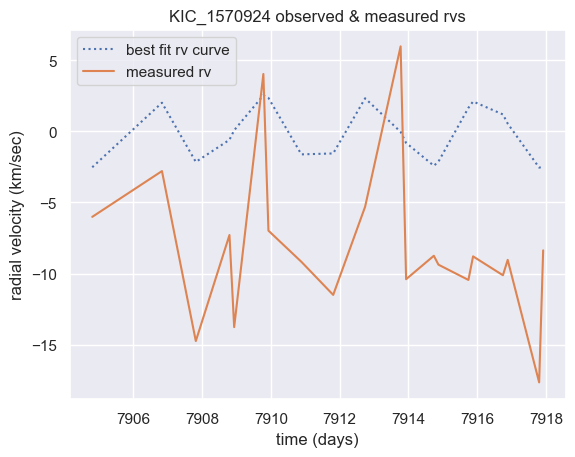

KIC target: KIC_3248885
max value is  1072.6672070903792
min value is  142.07342724598763
theta value is  0.5825620101572453 rad
q value is  0.11220522536231226
inclination angle value is  0.6871958787138748
Experimental p value =  [142.07342725]
Theoretical p value = 7.377758908227871
We do not have a binary system



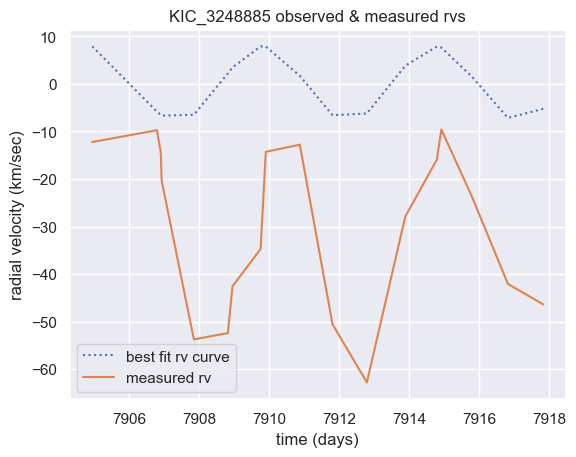

KIC target: KIC_3539632
max value is  1031.6872227820074
min value is  35.20503597909085
theta value is  1.8461934081036442 rad
q value is  0.10177651770013085
inclination angle value is  1.0841248426183494
Experimental p value =  [35.20503598]
Theoretical p value = 7.377758908227871
We do not have a binary system



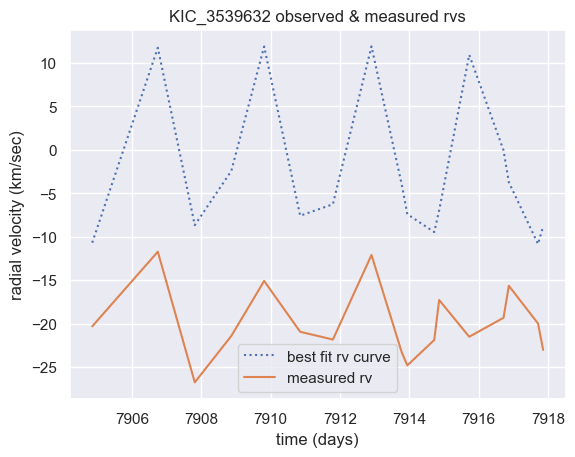

KIC target: KIC_3540728
max value is  1343.3565988917721
min value is  50.789546360565964
theta value is  2.5090807903937 rad
q value is  0.9055898479168051
inclination angle value is  0.07666346822319782
Experimental p value =  [50.78954636]
Theoretical p value = 7.377758908227871
We do not have a binary system



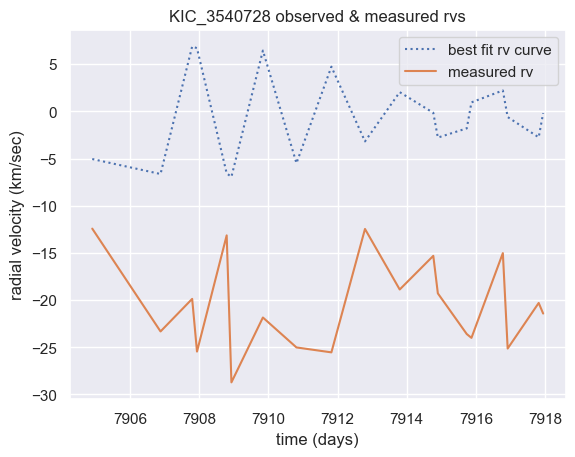

KIC target: KIC_4036736
max value is  976.8036063757377
min value is  51.41983048460161
theta value is  4.3134526009282625 rad
q value is  0.07085773097357151
inclination angle value is  0.9947849620580693
Experimental p value =  [51.41983048]
Theoretical p value = 7.377758908227871
We do not have a binary system



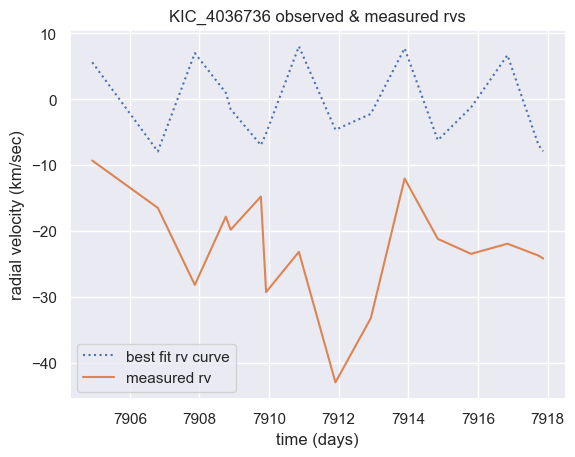

KIC target: KIC_4249702
max value is  840.2141098053622
min value is  52.03387569751892
theta value is  1.8461934081036442 rad
q value is  0.07085773097357151
inclination angle value is  0.6111657720528956
Experimental p value =  [52.0338757]
Theoretical p value = 7.377758908227871
We do not have a binary system



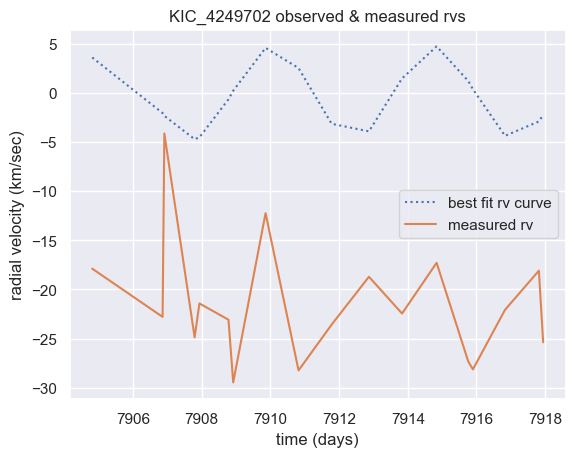

KIC target: KIC_4454890
max value is  1383.434033857404
min value is  58.07702649300747
theta value is  2.7478179065532253 rad
q value is  0.10177651770013085
inclination angle value is  1.0915322035360786
Experimental p value =  [58.07702649]
Theoretical p value = 7.377758908227871
We do not have a binary system



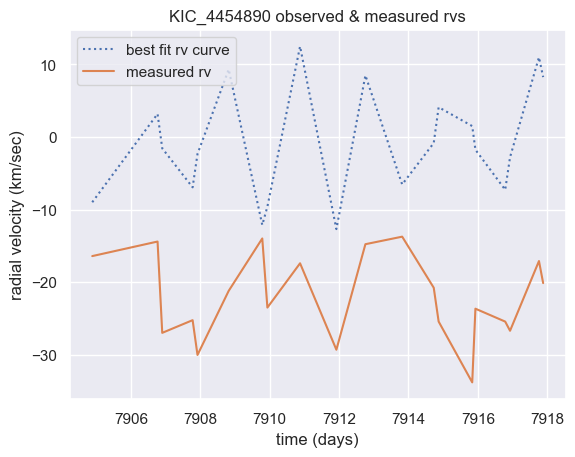

KIC target: KIC_4480434
max value is  992.3793765217372
min value is  99.25854093938696
theta value is  4.055324249250065 rad
q value is  0.11220522536231226
inclination angle value is  1.3155909443843603
Experimental p value =  [99.25854094]
Theoretical p value = 7.377758908227871
We do not have a binary system



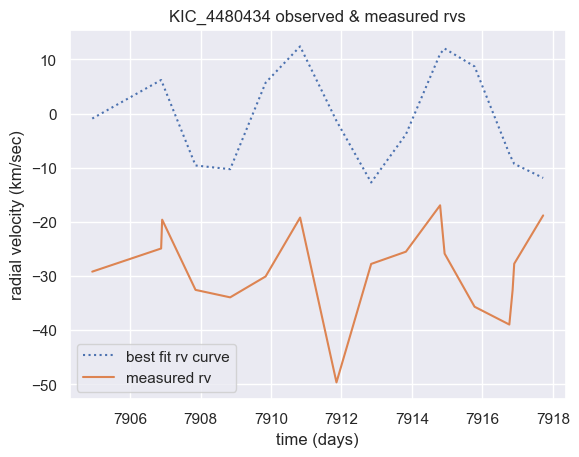

KIC target: KIC_5213142
max value is  984.9677990833984
min value is  9.172725634418937
theta value is  0.5825620101572453 rad
q value is  0.10177651770013085
inclination angle value is  0.2001381670241152
Experimental p value =  [9.17272563]
Theoretical p value = 7.377758908227871
We do not have a binary system



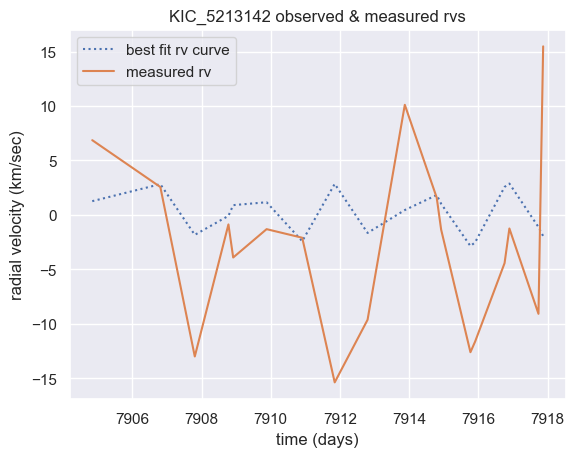

KIC target: KIC_5553362
max value is  897.2031120799787
min value is  36.91784065077002
theta value is  3.289536710006472 rad
q value is  0.07085773097357151
inclination angle value is  1.204134562904152
Experimental p value =  [36.91784065]
Theoretical p value = 7.377758908227871
We do not have a binary system



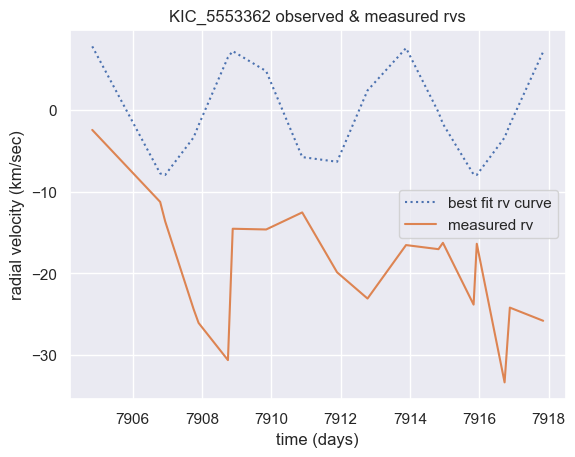

KIC target: KIC_6425783
max value is  885.1815229127833
min value is  74.87093546027495
theta value is  0.4383777479927655 rad
q value is  0.1052123303853163
inclination angle value is  0.07666346822319782
Experimental p value =  [74.87093546]
Theoretical p value = 7.377758908227871
We do not have a binary system



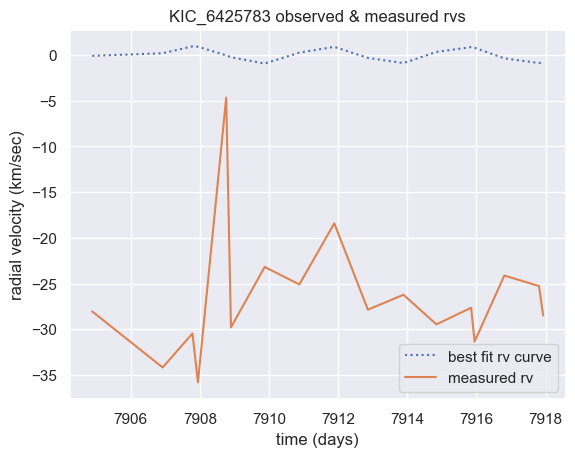

KIC target: KIC_6780052
max value is  1061.8442666182711
min value is  52.65295314610839
theta value is  2.958539096229838 rad
q value is  0.10177651770013085
inclination angle value is  1.308637142863939
Experimental p value =  [52.65295315]
Theoretical p value = 7.377758908227871
We do not have a binary system



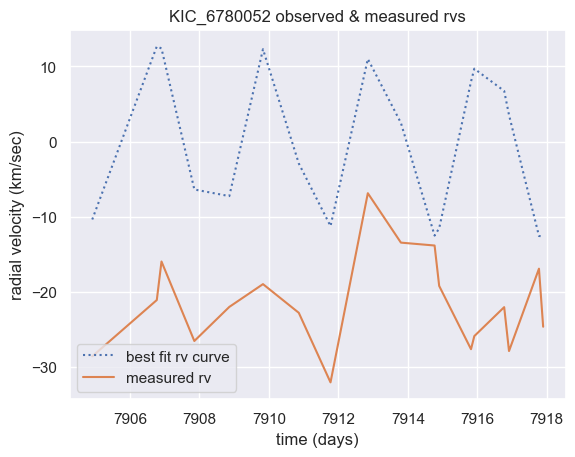

KIC target: KIC_6844101
max value is  1215.5027536088396
min value is  60.35692733404739
theta value is  3.7947648411064177 rad
q value is  0.7174886209411484
inclination angle value is  0.07666346822319782
Experimental p value =  [60.35692733]
Theoretical p value = 7.377758908227871
We do not have a binary system



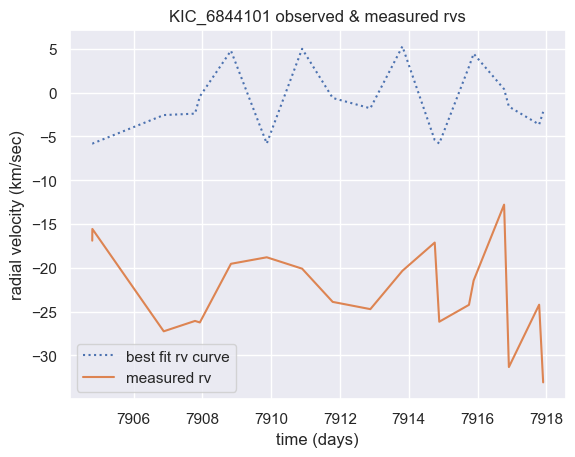

KIC target: KIC_7421325
max value is  786.7515379367521
min value is  24.11323504119584
theta value is  0.4383777479927655 rad
q value is  0.10177651770013085
inclination angle value is  1.428991418941449
Experimental p value =  [24.11323504]
Theoretical p value = 7.377758908227871
We do not have a binary system



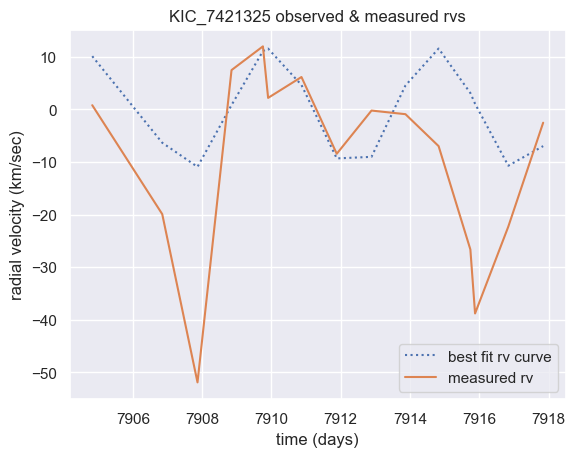

KIC target: KIC_7919763
max value is  972.9131945582831
min value is  44.02693231167837
theta value is  2.7478179065532253 rad
q value is  0.8016748618266619
inclination angle value is  0.07666346822319782
Experimental p value =  [44.02693231]
Theoretical p value = 7.377758908227871
We do not have a binary system



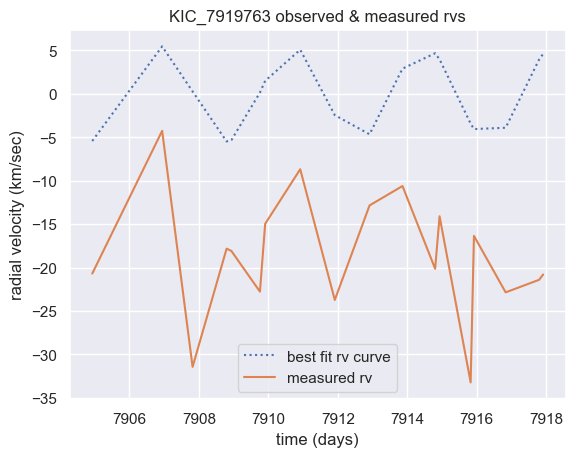

KIC target: KIC_8442720
max value is  1208.8463283397607
min value is  236.30691905367357
theta value is  0.005917545800181672 rad
q value is  0.9055898479168051
inclination angle value is  0.2001381670241152
Experimental p value =  [236.30691905]
Theoretical p value = 7.377758908227871
We do not have a binary system



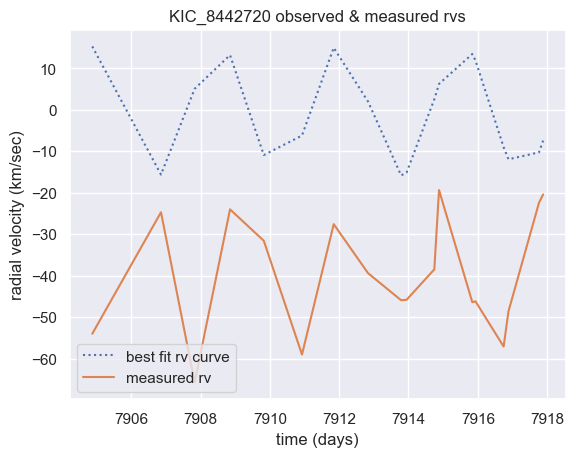

KIC target: KIC_8651471
max value is  747.9553278427665
min value is  6.786939049050683
theta value is  4.753666969989699 rad
q value is  0.07085773097357151
inclination angle value is  0.5918038667912556
Experimental p value =  [6.78693905]
Theoretical p value = 7.377758908227871
We have a binary system



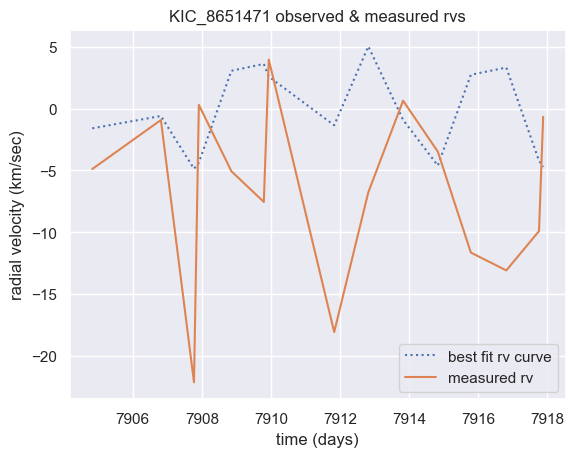

KIC target: KIC_9151271
max value is  2779.8091966767274
min value is  535.8958671120803
theta value is  3.289536710006472 rad
q value is  0.10177651770013085
inclination angle value is  0.07666346822319782
Experimental p value =  [535.89586711]
Theoretical p value = 7.377758908227871
We do not have a binary system



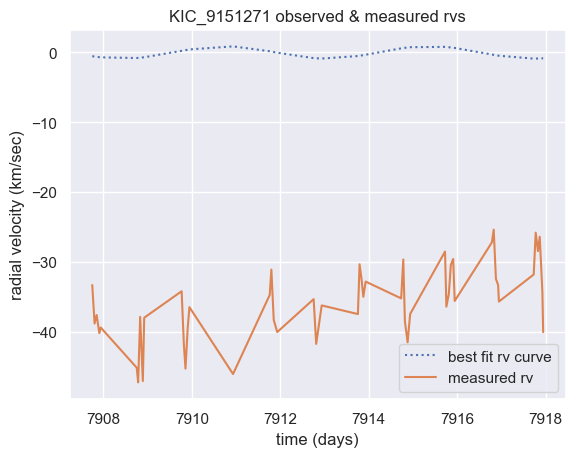

KIC target: KIC_9653110
max value is  1174.7961435757018
min value is  139.9902959135769
theta value is  1.9211474711554777 rad
q value is  0.07085773097357151
inclination angle value is  1.3155909443843603
Experimental p value =  [139.99029591]
Theoretical p value = 7.377758908227871
We do not have a binary system



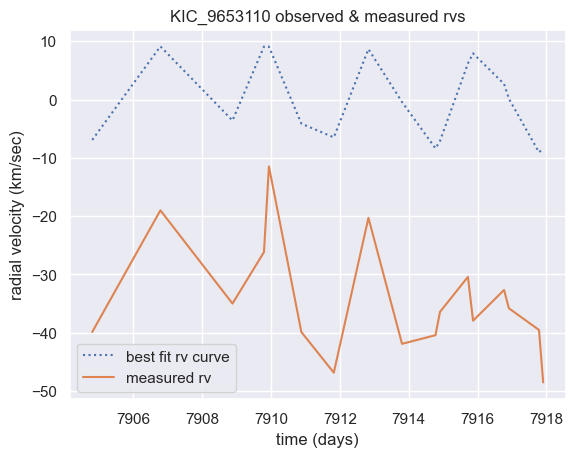

KIC target: KIC_9655045
max value is  295.49278980622296
min value is  0.49291264869009255
theta value is  2.76509034686405 rad
q value is  0.4103380789248914
inclination angle value is  0.2001381670241152
Experimental p value =  [0.49291265]
Theoretical p value = 7.377758908227871
We have a binary system



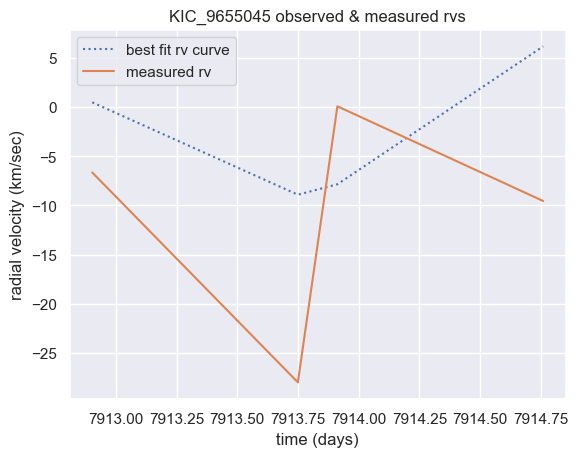

KIC target: KIC_9710336
max value is  997.5768020053807
min value is  56.786764852949084
theta value is  0.8503009059465786 rad
q value is  0.23067392719432622
inclination angle value is  0.6111657720528956
Experimental p value =  [56.78676485]
Theoretical p value = 7.377758908227871
We do not have a binary system



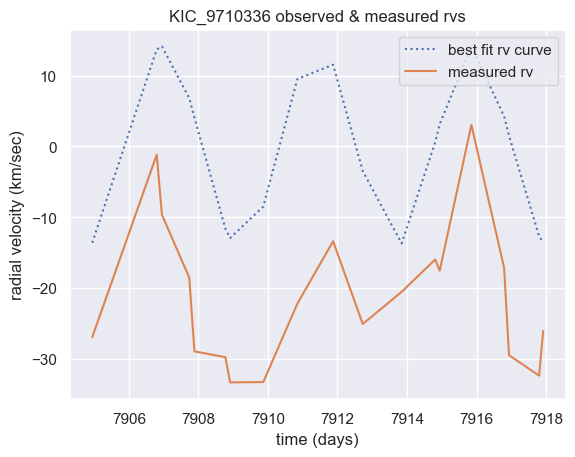

KIC target: KIC_9964938
max value is  923.8500208544772
min value is  4.492870862553377
theta value is  2.5090807903937 rad
q value is  0.07085773097357151
inclination angle value is  0.5918038667912556
Experimental p value =  [4.49287086]
Theoretical p value = 7.377758908227871
We have a binary system



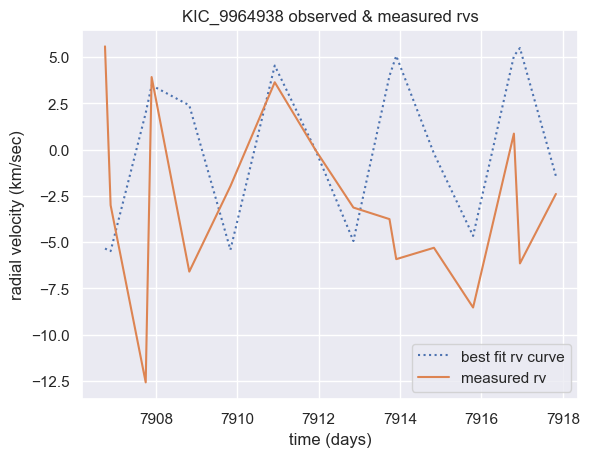

KIC target: KIC_11819949
max value is  1269.044959914625
min value is  9.98440919113233
theta value is  0.4383777479927655 rad
q value is  0.28672874794354875
inclination angle value is  0.3155545314712669
Experimental p value =  [9.98440919]
Theoretical p value = 7.377758908227871
We do not have a binary system



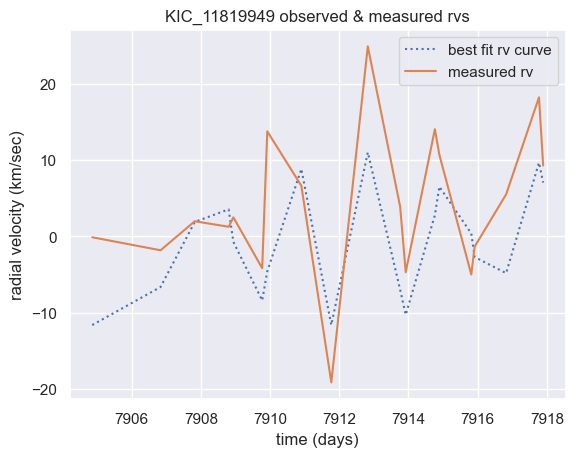

KIC target: KIC_12736892
max value is  1037.9967267012855
min value is  8.561080967491781
theta value is  0.005917545800181672 rad
q value is  0.582553827652172
inclination angle value is  0.3155545314712669
Experimental p value =  [8.56108097]
Theoretical p value = 7.377758908227871
We do not have a binary system



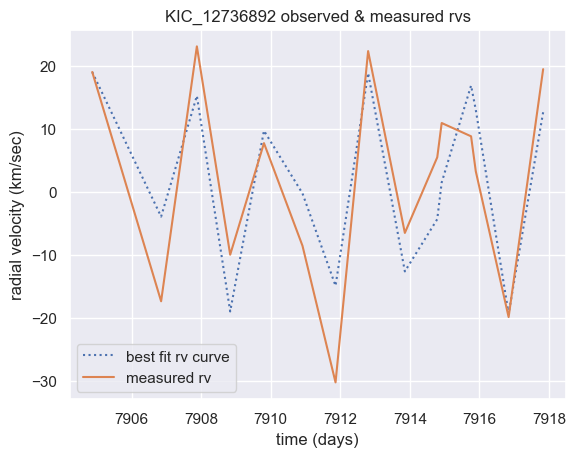

In [13]:
Run_Model()